In [9]:
import numpy as np
import random
import torch
import torch.nn as nn
import gym
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.patches as patches

class Qfunction(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.linear_1 = nn.Linear(state_dim, 64)
        self.linear_2 = nn.Linear(64, 64)
        self.linear_3 = nn.Linear(64, action_dim)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, states):
        hidden = self.linear_1(states)
        hidden = self.activation(hidden)
        hidden = self.linear_2(hidden)
        hidden = self.activation(hidden)
        actions = self.linear_3(hidden)
        return actions

In [10]:
%matplotlib inline

In [11]:
env = gym.make('LunarLander-v2',continuous = True)

In [12]:
class SDQN:
    def __init__(self, state_dim, action_dim, gamma=0.993, lr=1e-3, batch_size=128, epsilon_decrease=0.01, epsilon_min=0.03):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_function = Qfunction(self.state_dim, self.action_dim)
        self.q_function_ = Qfunction(self.state_dim, self.action_dim)
        for target_param in self.q_function_.parameters():
            target_param.data.copy_(target_param.data)
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = 1
        self.epsilon_decrease = epsilon_decrease
        self.epsilon_min = epsilon_min
        self.memory = []
        self.memory_lim = 150000
        self.optimzaer = torch.optim.Adam(self.q_function.parameters(), lr=lr)

    def get_action(self, state, target= False):
        if(target):
            q_values = self.q_function_(torch.FloatTensor(state))
        else:
            q_values = self.q_function(torch.FloatTensor(state))
        argmax_action = torch.argmax(q_values,dim=-1)
        probs = self.epsilon * np.ones((argmax_action.shape[0],self.action_dim)) / self.action_dim
        probs[np.arange(argmax_action.shape[0]),argmax_action] += 1 - self.epsilon
        action = np.ones(q_values.shape[0], dtype=np.int32)
        for sample in range(q_values.shape[0]):
            action[sample] = np.random.choice(np.arange(self.action_dim), p=probs[sample,:])
        return action
    
    def fit(self, state, action, reward, done, next_state, tau):
        self.memory.append([state, action, reward, int(done), next_state])
        if(len(self.memory)>self.memory_lim):
            self.memory = self.memory[int(self.memory_lim*0.05):]
            self.memory = random.sample(self.memory, int(self.memory_lim*0.9))
            print('clear memory')
        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))
    
            targets = rewards + self.gamma * (1 - dones) * torch.max(self.q_function_(next_states), dim=1).values
            q_values = self.q_function(states)[torch.arange(self.batch_size), actions]
            
            loss = torch.mean((q_values - targets.detach()) ** 2)
            loss.backward()
            self.optimzaer.step()
            self.optimzaer.zero_grad()
            
            self.soft_update(self.q_function,self.q_function_, tau)
            
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrease
                
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [13]:
%%time
state_dim = env.observation_space.shape[0]
action_dim = 6

episode_n = 1000
t_max = 1000

agent_s = SDQN(state_dim, action_dim,epsilon_decrease=0.03/2000)
action_dict = [[0,0],[1,0],[1,-1],[1,1],[0,1],[0,-1]]

hist_s = []
hist_s_v = []
hist_s_v_disc = []
hist_s_v_ = []
hist_s_v_disc_ = []

for episode in range(episode_n):
    total_reward = 0

    state = env.reset()
    for t in range(t_max):
        action = agent_s.get_action([state])
        next_state, reward, done, _ = env.step(action_dict[action[0]])

        total_reward += reward
        agent_s.fit(state, int(action), reward, done, next_state,tau = 0.005)

        state = next_state

        if done:
            break
    
    hist_s.append(total_reward)
    
    #validate
    if(episode%10 == 0):
        eps = agent_s.epsilon
        agent_s.epsilon = 0
        total_reward = 0
        total_reward_disc = 0
        rew_mult = 1
        state = env.reset()
        for t in range(t_max):
            action = agent_s.get_action([state], True)
            next_state, reward, done, _ = env.step(action_dict[action[0]])

            total_reward += reward
            
            total_reward_disc += rew_mult*reward
            rew_mult *= agent_s.gamma

            state = next_state

            if done:
                break
        agent_s.epsilon = eps
        
        hist_s_v_.append(total_reward)
        hist_s_v_disc_.append(total_reward_disc)
        
    
    if(episode%10 == 0):
        eps = agent_s.epsilon
        agent_s.epsilon = 0
        total_reward = 0
        total_reward_disc = 0
        rew_mult = 1
        state = env.reset()
        for t in range(t_max):
            action = agent_s.get_action([state], False)
            next_state, reward, done, _ = env.step(action_dict[action[0]])

            total_reward += reward
            
            total_reward_disc += rew_mult*reward
            rew_mult *= agent_s.gamma

            state = next_state

            if done:
                break
        agent_s.epsilon = eps
        
        hist_s_v.append(total_reward)
        hist_s_v_disc.append(total_reward_disc)

    print(f'episode: {episode}, \
rew: {round(np.mean(hist_s[-100:]),2)}, \
v_: {round(np.mean(hist_s_v_[-10:]),2)}, \
v_disc_: {round(np.mean(hist_s_v_disc_[-10:]),2)}, \
v: {round(np.mean(hist_s_v[-10:]),2)}, \
v_disc: {round(np.mean(hist_s_v_disc[-10:]),2)}, \
epsilon: {round(agent_s.epsilon,2)}, \
mem: {len(agent_s.memory)}')

episode: 0, rew: -523.94, v_: -567.69, v_disc_: -382.17, v: -290.22, v_disc: -178.37, epsilon: 1.0, mem: 130
episode: 1, rew: -412.14, v_: -567.69, v_disc_: -382.17, v: -290.22, v_disc: -178.37, epsilon: 1.0, mem: 255
episode: 2, rew: -348.45, v_: -567.69, v_disc_: -382.17, v: -290.22, v_disc: -178.37, epsilon: 1.0, mem: 428
episode: 3, rew: -394.3, v_: -567.69, v_disc_: -382.17, v: -290.22, v_disc: -178.37, epsilon: 0.99, mem: 570
episode: 4, rew: -390.65, v_: -567.69, v_disc_: -382.17, v: -290.22, v_disc: -178.37, epsilon: 0.99, mem: 654
episode: 5, rew: -423.11, v_: -567.69, v_disc_: -382.17, v: -290.22, v_disc: -178.37, epsilon: 0.99, mem: 787
episode: 6, rew: -444.49, v_: -567.69, v_disc_: -382.17, v: -290.22, v_disc: -178.37, epsilon: 0.99, mem: 897
episode: 7, rew: -445.9, v_: -567.69, v_disc_: -382.17, v: -290.22, v_disc: -178.37, epsilon: 0.99, mem: 984
episode: 8, rew: -455.96, v_: -567.69, v_disc_: -382.17, v: -290.22, v_disc: -178.37, epsilon: 0.98, mem: 1227
episode: 9, re

episode: 75, rew: -249.12, v_: -172.23, v_disc_: -36.82, v: -189.08, v_disc: -12.75, epsilon: 0.81, mem: 12878
episode: 76, rew: -247.39, v_: -172.23, v_disc_: -36.82, v: -189.08, v_disc: -12.75, epsilon: 0.79, mem: 13878
episode: 77, rew: -246.03, v_: -172.23, v_disc_: -36.82, v: -189.08, v_disc: -12.75, epsilon: 0.79, mem: 14156
episode: 78, rew: -244.18, v_: -172.23, v_disc_: -36.82, v: -189.08, v_disc: -12.75, epsilon: 0.77, mem: 15156
episode: 79, rew: -241.78, v_: -172.23, v_disc_: -36.82, v: -189.08, v_disc: -12.75, epsilon: 0.77, mem: 15284
episode: 80, rew: -239.62, v_: -160.31, v_disc_: -31.8, v: -170.43, v_disc: -6.41, epsilon: 0.76, mem: 16284
episode: 81, rew: -237.11, v_: -160.31, v_disc_: -31.8, v: -170.43, v_disc: -6.41, epsilon: 0.74, mem: 17284
episode: 82, rew: -234.79, v_: -160.31, v_disc_: -31.8, v: -170.43, v_disc: -6.41, epsilon: 0.73, mem: 18284
episode: 83, rew: -234.3, v_: -160.31, v_disc_: -31.8, v: -170.43, v_disc: -6.41, epsilon: 0.72, mem: 19043
episode: 8

episode: 152, rew: -16.65, v_: 113.33, v_disc_: 48.81, v: -25.89, v_disc: 36.06, epsilon: 0.03, mem: 77667
episode: 153, rew: -14.78, v_: 113.33, v_disc_: 48.81, v: -25.89, v_disc: 36.06, epsilon: 0.03, mem: 78362
episode: 154, rew: -12.22, v_: 113.33, v_disc_: 48.81, v: -25.89, v_disc: 36.06, epsilon: 0.03, mem: 78997
episode: 155, rew: -10.16, v_: 113.33, v_disc_: 48.81, v: -25.89, v_disc: 36.06, epsilon: 0.03, mem: 79997
episode: 156, rew: -3.81, v_: 113.33, v_disc_: 48.81, v: -25.89, v_disc: 36.06, epsilon: 0.03, mem: 80305
episode: 157, rew: 1.44, v_: 113.33, v_disc_: 48.81, v: -25.89, v_disc: 36.06, epsilon: 0.03, mem: 80868
episode: 158, rew: 6.26, v_: 113.33, v_disc_: 48.81, v: -25.89, v_disc: 36.06, epsilon: 0.03, mem: 81249
episode: 159, rew: 6.62, v_: 113.33, v_disc_: 48.81, v: -25.89, v_disc: 36.06, epsilon: 0.03, mem: 82249
episode: 160, rew: 7.34, v_: 145.19, v_disc_: 47.48, v: 2.8, v_disc: 36.87, epsilon: 0.03, mem: 82669
episode: 161, rew: 13.48, v_: 145.19, v_disc_: 47

episode: 230, rew: 153.16, v_: 172.89, v_disc_: 46.48, v: 113.77, v_disc: 38.66, epsilon: 0.03, mem: 122653
episode: 231, rew: 154.12, v_: 172.89, v_disc_: 46.48, v: 113.77, v_disc: 38.66, epsilon: 0.03, mem: 122964
episode: 232, rew: 154.58, v_: 172.89, v_disc_: 46.48, v: 113.77, v_disc: 38.66, epsilon: 0.03, mem: 123443
episode: 233, rew: 156.37, v_: 172.89, v_disc_: 46.48, v: 113.77, v_disc: 38.66, epsilon: 0.03, mem: 123964
episode: 234, rew: 156.55, v_: 172.89, v_disc_: 46.48, v: 113.77, v_disc: 38.66, epsilon: 0.03, mem: 124357
episode: 235, rew: 157.92, v_: 172.89, v_disc_: 46.48, v: 113.77, v_disc: 38.66, epsilon: 0.03, mem: 124739
episode: 236, rew: 156.19, v_: 172.89, v_disc_: 46.48, v: 113.77, v_disc: 38.66, epsilon: 0.03, mem: 125739
episode: 237, rew: 157.1, v_: 172.89, v_disc_: 46.48, v: 113.77, v_disc: 38.66, epsilon: 0.03, mem: 126276
episode: 238, rew: 157.24, v_: 172.89, v_disc_: 46.48, v: 113.77, v_disc: 38.66, epsilon: 0.03, mem: 126494
episode: 239, rew: 158.26, v_

episode: 306, rew: 221.05, v_: 228.02, v_disc_: 65.67, v: 211.33, v_disc: 73.47, epsilon: 0.03, mem: 140919
episode: 307, rew: 220.12, v_: 228.02, v_disc_: 65.67, v: 211.33, v_disc: 73.47, epsilon: 0.03, mem: 141278
episode: 308, rew: 220.17, v_: 228.02, v_disc_: 65.67, v: 211.33, v_disc: 73.47, epsilon: 0.03, mem: 141759
episode: 309, rew: 220.67, v_: 228.02, v_disc_: 65.67, v: 211.33, v_disc: 73.47, epsilon: 0.03, mem: 142160
episode: 310, rew: 220.87, v_: 231.48, v_disc_: 70.32, v: 196.93, v_disc: 72.81, epsilon: 0.03, mem: 142416
episode: 311, rew: 221.18, v_: 231.48, v_disc_: 70.32, v: 196.93, v_disc: 72.81, epsilon: 0.03, mem: 142822
episode: 312, rew: 221.08, v_: 231.48, v_disc_: 70.32, v: 196.93, v_disc: 72.81, epsilon: 0.03, mem: 143158
episode: 313, rew: 222.47, v_: 231.48, v_disc_: 70.32, v: 196.93, v_disc: 72.81, epsilon: 0.03, mem: 143396
episode: 314, rew: 222.25, v_: 231.48, v_disc_: 70.32, v: 196.93, v_disc: 72.81, epsilon: 0.03, mem: 143725
episode: 315, rew: 222.2, v_

episode: 382, rew: 205.58, v_: 224.33, v_disc_: 78.58, v: 158.46, v_disc: 60.79, epsilon: 0.03, mem: 147227
episode: 383, rew: 206.02, v_: 224.33, v_disc_: 78.58, v: 158.46, v_disc: 60.79, epsilon: 0.03, mem: 147460
episode: 384, rew: 205.47, v_: 224.33, v_disc_: 78.58, v: 158.46, v_disc: 60.79, epsilon: 0.03, mem: 147695
episode: 385, rew: 202.78, v_: 224.33, v_disc_: 78.58, v: 158.46, v_disc: 60.79, epsilon: 0.03, mem: 148695
episode: 386, rew: 201.15, v_: 224.33, v_disc_: 78.58, v: 158.46, v_disc: 60.79, epsilon: 0.03, mem: 149510
episode: 387, rew: 201.05, v_: 224.33, v_disc_: 78.58, v: 158.46, v_disc: 60.79, epsilon: 0.03, mem: 149776
clear memory
episode: 388, rew: 200.22, v_: 224.33, v_disc_: 78.58, v: 158.46, v_disc: 60.79, epsilon: 0.03, mem: 135245
episode: 389, rew: 196.21, v_: 224.33, v_disc_: 78.58, v: 158.46, v_disc: 60.79, epsilon: 0.03, mem: 135767
episode: 390, rew: 193.62, v_: 228.05, v_disc_: 80.46, v: 160.43, v_disc: 65.52, epsilon: 0.03, mem: 136157
episode: 391, r

episode: 458, rew: 203.36, v_: 233.89, v_disc_: 79.9, v: 174.69, v_disc: 80.03, epsilon: 0.03, mem: 147779
episode: 459, rew: 202.37, v_: 233.89, v_disc_: 79.9, v: 174.69, v_disc: 80.03, epsilon: 0.03, mem: 148779
episode: 460, rew: 205.68, v_: 240.91, v_disc_: 87.38, v: 187.37, v_disc: 82.46, epsilon: 0.03, mem: 149165
episode: 461, rew: 205.29, v_: 240.91, v_disc_: 87.38, v: 187.37, v_disc: 82.46, epsilon: 0.03, mem: 149509
episode: 462, rew: 205.59, v_: 240.91, v_disc_: 87.38, v: 187.37, v_disc: 82.46, epsilon: 0.03, mem: 149858
clear memory
episode: 463, rew: 206.27, v_: 240.91, v_disc_: 87.38, v: 187.37, v_disc: 82.46, epsilon: 0.03, mem: 135116
episode: 464, rew: 210.03, v_: 240.91, v_disc_: 87.38, v: 187.37, v_disc: 82.46, epsilon: 0.03, mem: 135558
episode: 465, rew: 212.03, v_: 240.91, v_disc_: 87.38, v: 187.37, v_disc: 82.46, epsilon: 0.03, mem: 135874
episode: 466, rew: 213.55, v_: 240.91, v_disc_: 87.38, v: 187.37, v_disc: 82.46, epsilon: 0.03, mem: 136109
episode: 467, rew

episode: 534, rew: 244.62, v_: 234.46, v_disc_: 71.41, v: 172.0, v_disc: 64.12, epsilon: 0.03, mem: 141679
episode: 535, rew: 244.13, v_: 234.46, v_disc_: 71.41, v: 172.0, v_disc: 64.12, epsilon: 0.03, mem: 141998
episode: 536, rew: 244.06, v_: 234.46, v_disc_: 71.41, v: 172.0, v_disc: 64.12, epsilon: 0.03, mem: 142284
episode: 537, rew: 243.75, v_: 234.46, v_disc_: 71.41, v: 172.0, v_disc: 64.12, epsilon: 0.03, mem: 142479
episode: 538, rew: 244.93, v_: 234.46, v_disc_: 71.41, v: 172.0, v_disc: 64.12, epsilon: 0.03, mem: 142777
episode: 539, rew: 245.49, v_: 234.46, v_disc_: 71.41, v: 172.0, v_disc: 64.12, epsilon: 0.03, mem: 143128
episode: 540, rew: 246.14, v_: 229.16, v_disc_: 71.68, v: 168.9, v_disc: 61.44, epsilon: 0.03, mem: 143369
episode: 541, rew: 244.83, v_: 229.16, v_disc_: 71.68, v: 168.9, v_disc: 61.44, epsilon: 0.03, mem: 144369
episode: 542, rew: 245.2, v_: 229.16, v_disc_: 71.68, v: 168.9, v_disc: 61.44, epsilon: 0.03, mem: 144585
episode: 543, rew: 246.51, v_: 229.16,

episode: 611, rew: 234.35, v_: 263.45, v_disc_: 91.09, v: 170.66, v_disc: 33.98, epsilon: 0.03, mem: 139075
episode: 612, rew: 234.72, v_: 263.45, v_disc_: 91.09, v: 170.66, v_disc: 33.98, epsilon: 0.03, mem: 139251
episode: 613, rew: 234.27, v_: 263.45, v_disc_: 91.09, v: 170.66, v_disc: 33.98, epsilon: 0.03, mem: 140199
episode: 614, rew: 234.17, v_: 263.45, v_disc_: 91.09, v: 170.66, v_disc: 33.98, epsilon: 0.03, mem: 140412
episode: 615, rew: 233.97, v_: 263.45, v_disc_: 91.09, v: 170.66, v_disc: 33.98, epsilon: 0.03, mem: 140573
episode: 616, rew: 225.25, v_: 263.45, v_disc_: 91.09, v: 170.66, v_disc: 33.98, epsilon: 0.03, mem: 140647
episode: 617, rew: 217.67, v_: 263.45, v_disc_: 91.09, v: 170.66, v_disc: 33.98, epsilon: 0.03, mem: 140727
episode: 618, rew: 216.28, v_: 263.45, v_disc_: 91.09, v: 170.66, v_disc: 33.98, epsilon: 0.03, mem: 141567
episode: 619, rew: 216.59, v_: 263.45, v_disc_: 91.09, v: 170.66, v_disc: 33.98, epsilon: 0.03, mem: 141764
episode: 620, rew: 216.07, v

episode: 687, rew: 205.53, v_: 271.62, v_disc_: 103.86, v: 151.96, v_disc: 33.04, epsilon: 0.03, mem: 145602
episode: 688, rew: 205.77, v_: 271.62, v_disc_: 103.86, v: 151.96, v_disc: 33.04, epsilon: 0.03, mem: 145892
episode: 689, rew: 205.76, v_: 271.62, v_disc_: 103.86, v: 151.96, v_disc: 33.04, epsilon: 0.03, mem: 146152
episode: 690, rew: 206.07, v_: 264.28, v_disc_: 104.94, v: 152.33, v_disc: 29.19, epsilon: 0.03, mem: 146561
episode: 691, rew: 206.08, v_: 264.28, v_disc_: 104.94, v: 152.33, v_disc: 29.19, epsilon: 0.03, mem: 146879
episode: 692, rew: 206.22, v_: 264.28, v_disc_: 104.94, v: 152.33, v_disc: 29.19, epsilon: 0.03, mem: 147093
episode: 693, rew: 206.34, v_: 264.28, v_disc_: 104.94, v: 152.33, v_disc: 29.19, epsilon: 0.03, mem: 147340
episode: 694, rew: 207.02, v_: 264.28, v_disc_: 104.94, v: 152.33, v_disc: 29.19, epsilon: 0.03, mem: 147545
episode: 695, rew: 207.72, v_: 264.28, v_disc_: 104.94, v: 152.33, v_disc: 29.19, epsilon: 0.03, mem: 147885
episode: 696, rew: 

episode: 763, rew: 243.2, v_: 238.22, v_disc_: 95.83, v: 194.15, v_disc: 82.55, epsilon: 0.03, mem: 139172
episode: 764, rew: 243.11, v_: 238.22, v_disc_: 95.83, v: 194.15, v_disc: 82.55, epsilon: 0.03, mem: 139503
episode: 765, rew: 241.21, v_: 238.22, v_disc_: 95.83, v: 194.15, v_disc: 82.55, epsilon: 0.03, mem: 140503
episode: 766, rew: 241.24, v_: 238.22, v_disc_: 95.83, v: 194.15, v_disc: 82.55, epsilon: 0.03, mem: 140730
episode: 767, rew: 241.31, v_: 238.22, v_disc_: 95.83, v: 194.15, v_disc: 82.55, epsilon: 0.03, mem: 140978
episode: 768, rew: 241.88, v_: 238.22, v_disc_: 95.83, v: 194.15, v_disc: 82.55, epsilon: 0.03, mem: 141232
episode: 769, rew: 242.03, v_: 238.22, v_disc_: 95.83, v: 194.15, v_disc: 82.55, epsilon: 0.03, mem: 141467
episode: 770, rew: 241.91, v_: 232.93, v_disc_: 89.72, v: 201.48, v_disc: 91.74, epsilon: 0.03, mem: 141945
episode: 771, rew: 241.76, v_: 232.93, v_disc_: 89.72, v: 201.48, v_disc: 91.74, epsilon: 0.03, mem: 142371
episode: 772, rew: 242.16, v_

episode: 839, rew: 222.95, v_: 150.86, v_disc_: 59.3, v: 236.32, v_disc: 90.85, epsilon: 0.03, mem: 147128
episode: 840, rew: 221.53, v_: 149.23, v_disc_: 59.27, v: 236.09, v_disc: 92.92, epsilon: 0.03, mem: 148128
episode: 841, rew: 221.26, v_: 149.23, v_disc_: 59.27, v: 236.09, v_disc: 92.92, epsilon: 0.03, mem: 148372
episode: 842, rew: 222.55, v_: 149.23, v_disc_: 59.27, v: 236.09, v_disc: 92.92, epsilon: 0.03, mem: 148905
episode: 843, rew: 222.44, v_: 149.23, v_disc_: 59.27, v: 236.09, v_disc: 92.92, epsilon: 0.03, mem: 149067
episode: 844, rew: 222.86, v_: 149.23, v_disc_: 59.27, v: 236.09, v_disc: 92.92, epsilon: 0.03, mem: 149305
episode: 845, rew: 222.96, v_: 149.23, v_disc_: 59.27, v: 236.09, v_disc: 92.92, epsilon: 0.03, mem: 149463
episode: 846, rew: 223.31, v_: 149.23, v_disc_: 59.27, v: 236.09, v_disc: 92.92, epsilon: 0.03, mem: 149753
episode: 847, rew: 223.27, v_: 149.23, v_disc_: 59.27, v: 236.09, v_disc: 92.92, epsilon: 0.03, mem: 149938
clear memory
episode: 848, re

episode: 916, rew: 130.27, v_: 181.49, v_disc_: 86.43, v: 187.61, v_disc: 64.44, epsilon: 0.03, mem: 137973
episode: 917, rew: 127.07, v_: 181.49, v_disc_: 86.43, v: 187.61, v_disc: 64.44, epsilon: 0.03, mem: 138062
episode: 918, rew: 122.18, v_: 181.49, v_disc_: 86.43, v: 187.61, v_disc: 64.44, epsilon: 0.03, mem: 138159
episode: 919, rew: 126.34, v_: 181.49, v_disc_: 86.43, v: 187.61, v_disc: 64.44, epsilon: 0.03, mem: 138497
episode: 920, rew: 125.45, v_: 127.6, v_disc_: 55.09, v: 185.34, v_disc: 65.63, epsilon: 0.03, mem: 138615
episode: 921, rew: 118.3, v_: 127.6, v_disc_: 55.09, v: 185.34, v_disc: 65.63, epsilon: 0.03, mem: 138708
episode: 922, rew: 118.57, v_: 127.6, v_disc_: 55.09, v: 185.34, v_disc: 65.63, epsilon: 0.03, mem: 138935
episode: 923, rew: 113.88, v_: 127.6, v_disc_: 55.09, v: 185.34, v_disc: 65.63, epsilon: 0.03, mem: 139038
episode: 924, rew: 110.64, v_: 127.6, v_disc_: 55.09, v: 185.34, v_disc: 65.63, epsilon: 0.03, mem: 140038
episode: 925, rew: 107.5, v_: 127.

episode: 992, rew: -273.0, v_: -133.19, v_disc_: -95.67, v: -218.39, v_disc: -63.17, epsilon: 0.03, mem: 149500
episode: 993, rew: -276.28, v_: -133.19, v_disc_: -95.67, v: -218.39, v_disc: -63.17, epsilon: 0.03, mem: 149674
clear memory
episode: 994, rew: -284.81, v_: -133.19, v_disc_: -95.67, v: -218.39, v_disc: -63.17, epsilon: 0.03, mem: 135011
episode: 995, rew: -288.97, v_: -133.19, v_disc_: -95.67, v: -218.39, v_disc: -63.17, epsilon: 0.03, mem: 135132
episode: 996, rew: -292.62, v_: -133.19, v_disc_: -95.67, v: -218.39, v_disc: -63.17, epsilon: 0.03, mem: 135186
episode: 997, rew: -295.68, v_: -133.19, v_disc_: -95.67, v: -218.39, v_disc: -63.17, epsilon: 0.03, mem: 135296
episode: 998, rew: -302.3, v_: -133.19, v_disc_: -95.67, v: -218.39, v_disc: -63.17, epsilon: 0.03, mem: 135406
episode: 999, rew: -308.49, v_: -133.19, v_disc_: -95.67, v: -218.39, v_disc: -63.17, epsilon: 0.03, mem: 135537
CPU times: total: 1h 18min
Wall time: 36min 19s


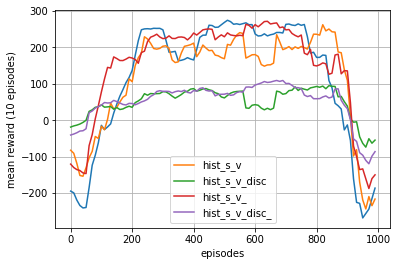

In [14]:
plt.grid(True)
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s[::10],np.ones(10)/10,mode='same'))
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v,np.ones(10)/10,mode='same'),label='hist_s_v')
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v_disc,np.ones(10)/10,mode='same'),label='hist_s_v_disc')
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v_,np.ones(10)/10,mode='same'),label='hist_s_v_')
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v_disc_,np.ones(10)/10,mode='same'),label='hist_s_v_disc_')
plt.xlabel('episodes')
plt.ylabel('mean reward (10 episodes)')
plt.legend()

In [15]:
hist = np.array([[i for i in range(len(hist_s))],hist_s]).T

In [16]:
np.savetxt('st4.txt',hist)